<a href="https://colab.research.google.com/github/fatmaT2001/QuantumLightsOutSolver/blob/main/LightsOutPuzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Solving the Lights Out Puzzle Using Grover's Algorithm</center></h1>
<h2><center>Course Project</center></h2>
<h3><center>CIE470</center></h3>
<h3><center>Introduction to Quantum Information and Computation</center></h3>

## Problem description:
The Puzzle consists of an NxN grid of bulbs, where each bulb occupied a cell on the grid, and has its own switch, which when pressed switches the state of the bulb between "on <----> off". The grid starts off in an initial state of on-&-off bulbs, and you need to find the sequence of switch presses that would "turn off all the lights", hence the name, "Lights-Out-Puzzle".  


Consider the initial state in the picture attached in the file, with yellow meaning the coresponding bulb is on, this is the setup we will have to solve for. This corresponds to initial state :[0, 1, 1, 0, 0, 1, 1, 0, 0]

then your goal is to find the new state of the switches (either to leave it in the same initial state, 0, or flip the switch,1)

> Indented block



In [ ]:
!pip install qiskit
!pip install qiskit-aer


In [ ]:
from qiskit.tools.visualization import *

## Steps:

## Solution:


### A. Preparing registers before we initiate the states and apply an oracle and a Diffuser:

### Q2: Iterations can be determined by :


Q2: Describe how we determine the number of iterations and set the number of iterations for our case:

The Value of the iterations depends on the Number of the Qubits used and for large number of N . $$r \approx \frac{\pi}{4} \sqrt{N} -\frac{1}{2}$$  where $$N = 2^n$$
and n is the used number of qubits  =9




In [ ]:
'''
Q2: set Iterations variable:

'''
import math
# change this
# Calculate the value of N
def iterations(number_of_qubits):
  N = math.pow(2, number_of_qubits)

  # Calculate the number of iterations based on the formula in Grover's Algorithem
  iteration = math.ceil((math.pi / 4) * math.sqrt(N)-(1/2))
  return iteration

### Q3: Circuit initialization for the given lights-out setup :

Describe your code for this step:  

The `initialize` function sets up the initial state of the circuit. It first initializes the state representing light bulbs based on the intial values `lights` by applying the Pauli-X gate to each qubit corresponding to a lit bulb (indicated by `1` in the `lights` array). Then, it prepares the  switches by applying the Hadamard gate  to each, generating a superposition of all possible states. Finally, it prepares an output qubit for phase kickback by first flipping its state with the Pauli-X gate and then applying the Hadamard gate to create the |-> state.

In [ ]:
def initialize(lights,qc,switch,bulb,output):
    '''Q3: Circuit initialization'''
    ## initialize:
    # Initialize bulbs based on the given lights configuration
    [qc.x(bulb[i]) for i in range(len(lights)) if lights[i] == 1]

    # second generate all possable statues using H gates for our switchs
    qc.h(switch)

    # Initialize the state of the output qubit for phase kickback
    qc.x(output) # to transvare |0> --> |1>
    qc.h(output) # to transvare |1> --> |->






### C. Construct the problem Oracle:

### Part 1 of the Oracle:  

#### Q4: We need to define a function for the first part of the oracle below, which takes the prepared quantum circuit, some switch state, and the given initial bulb-state, and finally acts on the bulb-state accordingly.

#### Hint: you will need a little bit more than 30 gates to achieve this.

**describe what your code does here for this step:**

The `switch_flip` function simulate the interaction between switches and light bulbs . For each switch the function uses a Controlled-NOT gate to toggle the state of the corresponding bulb  and also the states of the neighbors bulb of that switch.

The `switches_neighbors` matrix used in the `switch_flip` function is a  matrix that represents the relationships between each bulb and its neighboring bulbs in the quantum circuit. Each row in this matrix corresponds to a specific bulb, and the columns represent its neighbors. The matrix entries indicate which bulbs are neighbors to each other. When the function iterates through the switches, it uses this matrix to determine which neighboring bulbs are affected by the state of each switch. The Controlled-NOT gates are then applied between the switch qubit and the coresponding bulb in addation to the qubits of its neighbors.

In [ ]:
def switch_flip(number_of_qubits,qc,switch,bulb,switches_neighbors):
    # Apply CNOT gates between each switch and its corresponding bulb and neighbors
    for i in range(number_of_qubits):
        # Apply CNOT for the corresponding bulb
        qc.cx(switch[i], bulb[i])
        # Apply CNOT for the neighbors
        for neighbor in switches_neighbors[i]:
            qc.cx(switch[i], bulb[neighbor])


### Part 2 of the Oracle:

**Describe what your code does here for these two steps:**


#### Q5a: Complete the for loop below which runs our predetermined iterations of Grover.
-applies the first part of the oracle (by calling a function)  
-applies the second part of the oracle to check for the winner switch-state (Hint: a known gate can do this)  
-uncomputes (you should know what that is)  
-applies an appropriate diffuser  

#### Q5b: finally measure the output
Measure the switch-states from which we can infer the most probable answer.

NB:  you can use the "qc.reverse_bits()" function on a "qc"-quantum circuit object to reverse the order of the bits to avoid Qiskit's annoying convention.

The `phase_flip_target_statue` function manipulate the phase of a target state within our quantum circuit. It first applies Pauli-X gates to invert the states of all bulb qubits, changing the target state from `|00000000>` to `|11111111>`. Then, it uses a multi-controlled Toffoli gate, with the bulb qubits as controls and an output qubit as the target, to flip the phase of the target state. Finally, the function reverts the bulb qubits to their original states by reapplying Pauli-X gates, ensuring that only the phase of the target state is affected by the operation.

In [ ]:
def phase_flip_target_statue(number_of_qubits,qc,bulb,output):
    # Apply X gates to invert the target from |00000000> to |11111111>
    for i in range(number_of_qubits):
        qc.x(bulb[i])

    # Apply the multi-controlled Toffoli gate with all bulb qubits as controls
    # as X|-> = -|-> that will flip the sign of the targte state
    qc.mcx(bulb, output)

    # Reapply X gates to revert the bulb states to their original configuration
    for i in range(number_of_qubits):
        qc.x(bulb[i])




The `uncompute_switch_flip` function reverses the actions performed by `switch_flip`, aiming to unentangle and revert the states of qubits representing bulbs and switches back to their initial configuration. It accomplishes this by iterating over the switches in reverse order and applying Controlled-NOT  gates first to each switch's neighboring bulbs (also in reverse order), and then to the corresponding bulb. This reversal  ensures that any entanglement or state changes introduced in the circuit are undone, leaving the qubits in a clean state.

The uncompute step in a quantum algorithm is like pressing a reset button to undo any extra steps that were done earlier in the process. It makes sure that only the parts we care about (the target state) are left unchanged, while all the other changes are canceled out. This makes the target state stand out more when we look at the final results.  So, when we measure the quantum circuit after the uncompute step, the chance of seeing the target state is much higher.

this action directly influences the peak representing the target state's probability. It ensures that the amplitude of the target state is not affected  by the  effects of previous operations. By disentangling the qubits and reverting them to their original state, except for the phase flipped target, this way we  maximizes the target state's probability. This leads to a more pronounced and distinct peak in the graph for the target state, as observed in the second histogram provided earlier. In essence, the uncompute_switch_flip function is a critical step for achieving the desired outcome of the quantum search algorithm, which is to find the target state with high probability.

without using the uncompute_switch_flip


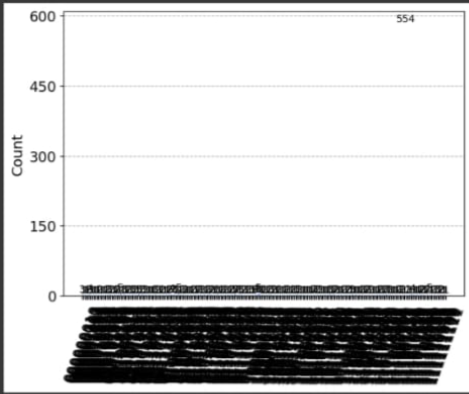



With using uncompute_switch_flip

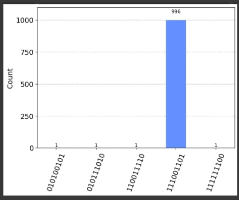

In [ ]:
def uncompute_switch_flip(number_of_qubits,qc,bulb,switch,switches_neighbors):
    # Reverse the order of switch processing
    for i in reversed(range(number_of_qubits)):
        # Reverse the order of neighbor processing
        for neighbor in reversed(switches_neighbors[i]):
            qc.cx(switch[i], bulb[neighbor])
        # Apply CNOT for the corresponding bulb
        qc.cx(switch[i], bulb[i])

The `apply_diffuser` function in a quantum algorithm can be understood geometrically using the concepts of the target state |w> and the superposition state |s>. In this geometric interpretation, consider the quantum states as vectors in a high-dimensional space.

Initially, the algorithm prepares the state |s>, a uniform superposition of all possible states, including the target state |w>. Geometrically, this is akin to positioning |s> at an equal angle to all basis states, including |w>. The Hadamard and Pauli-X gates applied during the apply_diffuser function act to invert the amplitudes of the states about the average amplitude, effectively reflecting the state vector about the axis defined by |s>.

The crucial part of the diffuser is the phase shift applied to |w> by the multi-controlled Toffoli gate. This operation flips the sign of the amplitude of |w>, resulting in a state that, when combined with the inversion about |s>, moves the overall state vector closer to |w>. Geometrically, this is equivalent to reflecting the state vector across the axis defined by |s> and then across the axis defined by |w>, which brings the state vector closer to |w>.

The overall effect of the apply_diffuser function is to increase the overlap between the state vector and the target state |w>. This results in an increased probability of observing |w> when the state is measured. As the algorithm iterates, this process is repeated, further amplifying the amplitude of |w> relative to the other states. Geometrically, with each iteration, the state vector rotates closer to the target state |w>, thereby increasing the likelihood of |w> being the observed state in a measurement.


In [ ]:
def apply_diffuser(qc,switch):

    qc.h(switch)

    qc.x(switch)

    qc.h(switch[-1])

    qc.mct(switch[0:-1], switch[-1])

    qc.h(switch[-1])

    qc.x(switch)

    qc.h(switch)

#### Q1: Register preparation :

In [ ]:
from qiskit import *

'''
Q1: Register preparation :
 construct the circuit "qc" given below by combining 4 inputs consisting of:

 3 quantum registers (switch, bulb, output) and a classical register (result) which returns an initial quantum circuit


'''
# Quantum registers
number_of_qubits=9

switch = QuantumRegister(number_of_qubits, name="switch")
bulb = QuantumRegister(number_of_qubits, name="bulb")
output = QuantumRegister(1, name="output")
# Classical register for measurement
result = ClassicalRegister(number_of_qubits, name="classical")

qc = QuantumCircuit(switch, bulb, output, result) ## a circuit combining all the registers



### F. Run the Grover-Circuit and use the measurement to obtain the solution:

In [ ]:
lights = [0, 1, 1, 0, 0, 1, 1, 0, 0] ## this is our variable holding the initial bulb states

switches_neighbors = [
    [1, 3],
    [0, 2, 4],
    [1, 5],
    [0, 4, 6],
    [1, 3, 5, 7],
    [2, 4, 8],
    [3, 7],
    [4, 6, 8],
    [5, 7]
]

iteration=iterations(number_of_qubits)

initialize(lights,qc,switch,bulb,output)
for i in range(iteration):
    '''Q5a:'''
    switch_flip(number_of_qubits,qc,switch,bulb,switches_neighbors)

    '''
    Multi-qubit controlled gate
    '''
    phase_flip_target_statue(number_of_qubits,qc,bulb,output)
    '''
    uncompute oracle

    '''
    uncompute_switch_flip(number_of_qubits,qc,bulb,switch,switches_neighbors)

    # diffuser
    apply_diffuser(qc,switch)

<ipython-input-9-5562f6edf6e2>:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(switch[0:-1], switch[-1])


In [ ]:
qc.measure(switch,result)
# Make the Output order the same as the input.
qc = qc.reverse_bits()

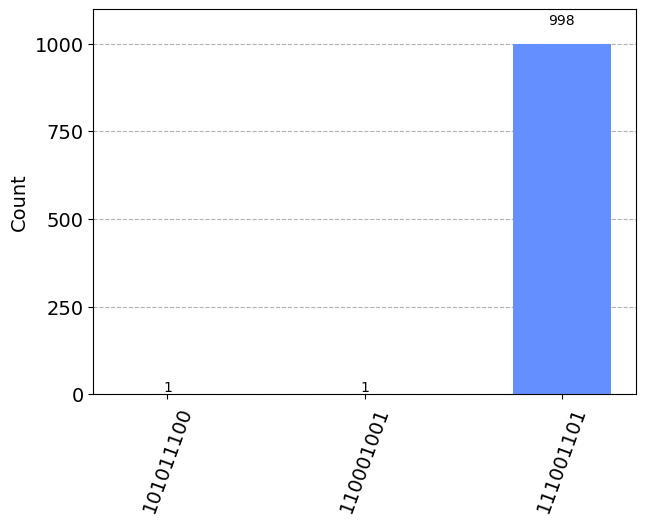

In [ ]:
## Running the completed Grover's circuit:
from qiskit.tools.visualization import *

sim = Aer.get_backend('qasm_simulator')

job = execute(qc, backend=sim, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Q6: Extract the solution form the results:

In [ ]:
# Find the key with the maximum value (most occurrences)
final_switches = max(counts, key=counts.get)
final_switches

'111001101'

'''   
Q6  
describe what your code does here for this final step, how do we extract the solution form the results:  
'''

extracting  the solution done through two functions to simulate the flipping of light bulbs.

 The `flip_switch_and_neighbors` function flips the state of a specific bulb and the bulbs connected to it, based on the `neighbors` configuration. The

`get_final_bulb_state` function uses this fliping logic to determine the final state of all bulbs after a sequence of switch flips. It iteratively goes through each switch, and if the switch is meant to be flipped (indicated by '1'), it calls the fliping function. The process is logged with print statements showing the current state of the bulbs and which switches are being flipped. This code is used to calculate the final configuration of the bulb states after all specified switches have been fliped.


In [ ]:
# Updated function to toggle the switch itself and its neighbors
def flip_switch_and_neighbors(bulb_state, index, neighbors):
    # Toggle the current switch's bulb and its neighbors
    print('to be fliped',[index] + neighbors[index])
    for idx in [index] + neighbors[index]:
        bulb_state[idx] = 1 - bulb_state[idx]

# Function to calculate the final state of the bulbs with the new toggle logic
def get_final_bulb_state(initial_state, switch_config, neighbors):
    final_state = initial_state[:]  # Copy the initial state
    for i in range(len(switch_config)):
        print('state',final_state)
        if switch_config[i] == '1':
            print('ones',i)
            flip_switch_and_neighbors(final_state, i, neighbors)
    return final_state


# Recalculate the final state of the bulbs with the new neighbor configuration
final_state_with_neighbors = get_final_bulb_state(lights, final_switches, switches_neighbors)
final_state_with_neighbors



state [0, 1, 1, 0, 0, 1, 1, 0, 0]
ones 0
to be fliped [0, 1, 3]
state [1, 0, 1, 1, 0, 1, 1, 0, 0]
ones 1
to be fliped [1, 0, 2, 4]
state [0, 1, 0, 1, 1, 1, 1, 0, 0]
ones 2
to be fliped [2, 1, 5]
state [0, 0, 1, 1, 1, 0, 1, 0, 0]
state [0, 0, 1, 1, 1, 0, 1, 0, 0]
state [0, 0, 1, 1, 1, 0, 1, 0, 0]
ones 5
to be fliped [5, 2, 4, 8]
state [0, 0, 0, 1, 0, 1, 1, 0, 1]
ones 6
to be fliped [6, 3, 7]
state [0, 0, 0, 0, 0, 1, 0, 1, 1]
state [0, 0, 0, 0, 0, 1, 0, 1, 1]
ones 8
to be fliped [8, 5, 7]


[0, 0, 0, 0, 0, 0, 0, 0, 0]

### Final Remarks: Wrap up your steps, talk briefly about your code and summarize the results and conclusion:  



In summary, the project is a simulation of a system of interconnected light bulbs controlled by switches, where each switch affects its own bulb and the bulbs of its neighboring switches. The code defines a method to flip the state of these bulbs according to a given switch configuration and neighboring setup.

Starting from initialization, the quantum circuit is set up with qubits representing light bulbs and switches, each initialized to a specific state according to the problem's requirements. The switches are placed in superposition to represent all possible combinations of on and off states. Next, operations are applied to simulate the effect of each switch on its corresponding bulb and neighboring bulbs, altering their states. A phase flip is introduced to mark the target solution, followed by an uncompute step to disentangle any auxiliary entanglement and revert the qubits back to a state that reflects only the necessary computation. A diffuser is then applied to amplify the probability of the target state, enhancing its distinguishability. Finally, the circuit is measured, collapsing the superposition to a single outcome, with the target state having a significantly higher probability of being observed , as evidenced by the histograms representing the results. T

The results of the simulation would show how a particular configuration of switches (on or off) and their respective neighbors affects the overall light bulb system.e.


Geometrically, this quantum algorithm can be visualized as a series of transformations in a high-dimensional space, where each quantum state is represented as a vector. The phase flip operation plays a pivotal role in this geometric interpretation. When the phase flip is applied, it effectively inverts the amplitude of the target state |w>. This inversion is akin to reflecting the state vector across the hyperplane orthogonal to |w>. The result is that the target state vector |w> and the current state vector acquire a relative phase difference, setting the stage for the diffuser's action.

The diffuser function, which follows the phase flip, acts to rotate the overall state vector closer to the target state |w> with each iteration. This rotation is achieved through a series of inversions about the average amplitude and the target state, geometrically equivalent to reflections in the high-dimensional space. The net effect is that the state vector gradually aligns more closely with the target state vector.

These combined transformations—the phase flip and the diffuser—work together to increase the overlap between the state vector and the target state |w>. As a result, the probability of observing the target state during measurement is significantly enhanced. The phase flip sets up the initial condition for the diffuser to effectively amplify the target state's probability amplitude, while simultaneously diminishing the amplitudes of non-target states.

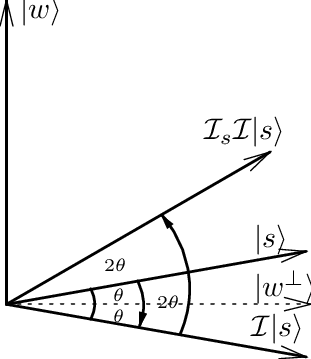

# Bonus

## Changes in Target Probability Through the Iterations







<ipython-input-9-5562f6edf6e2>:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(switch[0:-1], switch[-1])


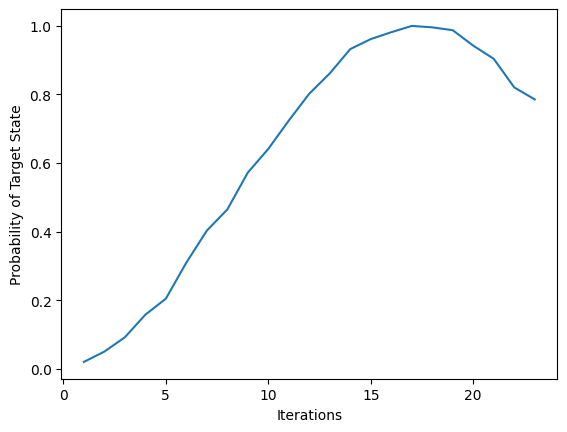

In [ ]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit import QuantumRegister, ClassicalRegister
import numpy as np

# Define the initial state of the lights and the neighbors for each switch
lights = [0, 1, 1, 0, 0, 1, 1, 0, 0]
switches_neighbors = [
    [1, 3],
    [0, 2, 4],
    [1, 5],
    [0, 4, 6],
    [1, 3, 5, 7],
    [2, 4, 8],
    [3, 7],
    [4, 6, 8],
    [5, 7]
]

number_of_qubits = 9
switch = QuantumRegister(number_of_qubits, name="switch")
bulb = QuantumRegister(number_of_qubits, name="bulb")
output = QuantumRegister(1, name="output")
result_re = ClassicalRegister(number_of_qubits, name="classical")

probabilities = []
for num_iter in range(1,iterations(number_of_qubits)+6):

    qc = QuantumCircuit(switch, bulb, output, result_re)

    # Initialize the circuit
    initialize(lights,qc,switch,bulb,output)

    for _ in range(num_iter):
        # Apply the quantum operations
        switch_flip(number_of_qubits,qc,switch,bulb,switches_neighbors)

        '''
        Multi-qubit controlled gate
        '''
        phase_flip_target_statue(number_of_qubits,qc,bulb,output)
        '''
        uncompute oracle

        '''
        uncompute_switch_flip(number_of_qubits,qc,bulb,switch,switches_neighbors)

        # diffuser
        apply_diffuser(qc,switch)

    qc.measure(switch, result_re)
    # Make the Output order the same as the input.
    qc = qc.reverse_bits()
    result = execute(qc, Aer.get_backend('qasm_simulator'), shots=1200).result()
    counts = result.get_counts(qc)

    # Calculate the probability of the target state
    target_state = "111001101"  # Define the target state
    prob = counts.get(target_state, 0) / 1200
    probabilities.append(prob)

# Plot the probabilities
import matplotlib.pyplot as plt
plt.plot(range(1, iterations(number_of_qubits) + 6), probabilities)
plt.xlabel('Iterations')
plt.ylabel('Probability of Target State')
plt.show()


From the graph, we can see that as the number of iterations increases, the probability of the target state initially increases, reaching its maximum at around 18 iterations. This is indicative of the amplitude amplification process typical in Grover's search algorithm, where the correct state's amplitude (and thus its probability) is increased with each iteration. However, after the optimal number of iterations (18 in this case), the probability starts to decrease. This decrease beyond the optimal number of iterations is due to the nature of Grover's algorithm, where the amplitude of the target state begins to oscillate and can decrease if the algorithm runs for too long, leading to over-amplification.

## General Algorithem

To enhance the flexibility of the code, it is essential to first generalize the method that determines the target state. This involves creating a function that can adapt to any specified target `generalized_phase_flip_target_statue`. Furthermore, it is necessary to develop a function that can accurately determine the neighbors of each switch, which will be based on the grid's dimensions and layout `generate_switch_neighbors_matrix`.

 For users to customize the simulation to their specific requirements, they must set the initial state of the light bulbs (`lights`), define the total number of qubits (`number_of_qubits`), and specify the desired target state (`target`). By making these elements configurable, the code can be tailored to a wide range of scenarios and quantum circuit configurations.

In [ ]:
def generalized_phase_flip_target_statue(target,number_of_qubits,qc,bulb,output):
    # Apply X gates to invert the qubits that are 0 in the target state to 1
    for i in range(number_of_qubits):
        if target[i] == 0:
            qc.x(bulb[i])

    # Apply the multi-controlled Toffoli gate with all bulb qubits as controls
    # This will flip the phase of the target state
    qc.mcx(bulb, output)

    # Reapply X gates to revert the qubits that were flipped for the target state to their original configuration
    for i in range(number_of_qubits):
        if target[i] == 0:
            qc.x(bulb[i])



In [ ]:
def generate_switch_neighbors_matrix(total_bulbs):
    switches_neighbors = []
    bulb_in_row = int(np.sqrt(total_bulbs))  # Calculate the number of bulbs per row (assuming a square grid)

    for i in range(total_bulbs):
        neighbors = []
        # Check for the switch above (unless we're on the top row)
        if i >= bulb_in_row:
            neighbors.append(i - bulb_in_row)
        # Check for the switch below (unless we're on the bottom row)
        if i < (total_bulbs - bulb_in_row):
            neighbors.append(i + bulb_in_row)
        # Check for the switch to the left (unless we're on the left edge)
        if i % bulb_in_row != 0:
            neighbors.append(i - 1)
        # Check for the switch to the right (unless we're on the right edge)
        if (i + 1) % bulb_in_row != 0:
            neighbors.append(i + 1)

        switches_neighbors.append(neighbors)

    return switches_neighbors



In [ ]:
def general_LightsOutPuzzle(number_of_qubits,lights,target):
  switches_neighbors=generate_switch_neighbors_matrix(number_of_qubits)
  #============= circut =================
  switch = QuantumRegister(number_of_qubits, name="switch")
  bulb = QuantumRegister(number_of_qubits, name="bulb")
  output = QuantumRegister(1, name="output")
  # Classical register for measurement
  result_req = ClassicalRegister(number_of_qubits, name="classical")
  qc = QuantumCircuit(switch, bulb, output, result_req)
  #=======================================

  iteration=iterations(number_of_qubits)

  initialize(lights,qc,switch,bulb,output)
  for i in range(iteration):
      '''Q5a:'''
      switch_flip(number_of_qubits,qc,switch,bulb,switches_neighbors)

      '''
      Multi-qubit controlled gate
      '''
      generalized_phase_flip_target_statue(target,number_of_qubits,qc,bulb,output)
      '''
      uncompute oracle

      '''
      uncompute_switch_flip(number_of_qubits,qc,bulb,switch,switches_neighbors)

      # diffuser
      apply_diffuser(qc,switch)


  qc.measure(switch,result_req)
  # Make the Output order the same as the input.
  qc = qc.reverse_bits()


  sim = Aer.get_backend('qasm_simulator')

  job = execute(qc, backend=sim, shots=1000)
  result = job.result()
  counts = result.get_counts(qc)
  return counts,switches_neighbors

### First Test Case 2 x *2*

In [ ]:
lights2_2 = [0, 1, 1, 0] ## this is our variable holding the initial bulb states
number_of_qubits2_2=4
target2_2=[0,0,0,1]

<ipython-input-9-5562f6edf6e2>:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(switch[0:-1], switch[-1])


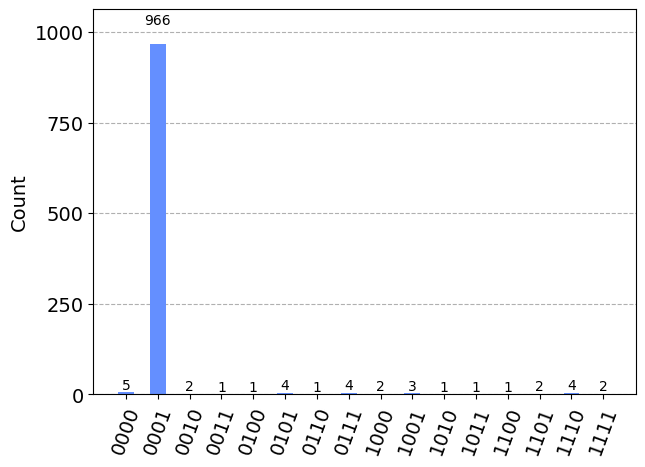

In [ ]:
## Running the completed Grover's circuit:
output2_2=general_LightsOutPuzzle(number_of_qubits2_2,lights2_2,target2_2)
counts2_2=output2_2[0]
plot_histogram(counts2_2)

In [ ]:
# Find the key with the maximum value (most occurrences)
final_switches2_2 = max( output2_2[0], key=output2_2[0].get)
print(final_switches2_2)
# Recalculate the final state of the bulbs with the new neighbor configuration
print(lights2_2, final_switches2_2, output2_2[1])
final_state_with_neighbors2_2 = get_final_bulb_state(lights2_2, final_switches2_2, output2_2[1])
final_state_with_neighbors2_2

0001
[0, 1, 1, 0] 0001 [[2, 1], [3, 0], [0, 3], [1, 2]]
state [0, 1, 1, 0]
state [0, 1, 1, 0]
state [0, 1, 1, 0]
state [0, 1, 1, 0]
ones 3
to be fliped [3, 1, 2]


[0, 0, 0, 1]

### second Test Case 3 x 3  

In [ ]:
lights3_3= [0, 1, 1, 0, 1, 0, 0, 1, 1]
number_of_qubits3_3 = 9
target3_3= [0, 0, 0, 1, 1, 1, 1, 0, 1]




<ipython-input-9-5562f6edf6e2>:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(switch[0:-1], switch[-1])


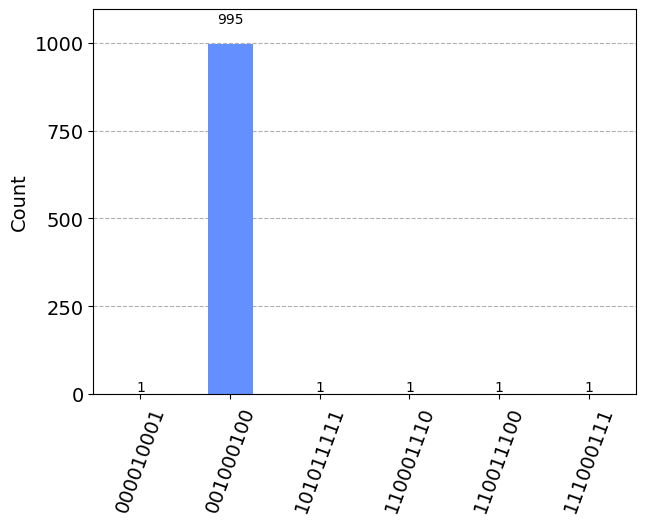

In [ ]:
## Running the completed Grover's circuit:
output3_3=general_LightsOutPuzzle(number_of_qubits3_3,lights3_3,target3_3)
counts3_3=output3_3[0]
plot_histogram(counts3_3)

In [ ]:
# Find the key with the maximum value (most occurrences)
final_switches3_3 = max( output3_3[0], key=output3_3[0].get)
# Recalculate the final state of the bulbs with the new neighbor configuration
final_state_with_neighbors3_3 = get_final_bulb_state(lights3_3, final_switches3_3, output3_3[1])
final_state_with_neighbors3_3

state [0, 1, 1, 0, 1, 0, 0, 1, 1]
state [0, 1, 1, 0, 1, 0, 0, 1, 1]
state [0, 1, 1, 0, 1, 0, 0, 1, 1]
ones 2
to be fliped [2, 5, 1]
state [0, 0, 0, 0, 1, 1, 0, 1, 1]
state [0, 0, 0, 0, 1, 1, 0, 1, 1]
state [0, 0, 0, 0, 1, 1, 0, 1, 1]
state [0, 0, 0, 0, 1, 1, 0, 1, 1]
ones 6
to be fliped [6, 3, 7]
state [0, 0, 0, 1, 1, 1, 1, 0, 1]
state [0, 0, 0, 1, 1, 1, 1, 0, 1]


[0, 0, 0, 1, 1, 1, 1, 0, 1]

### Third Test Case 4 x 4
did not work as the maximum qubits capacity of the quantumn cricut in qiskit is only 28

## Noise

In [ ]:
!pip install qiskit-aer


In [ ]:
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel, errors,pauli_error, amplitude_damping_error, thermal_relaxation_error


def general_LightsOutPuzzle_with_noise(number_of_qubits, lights, target, noise_level=0.01):
    switches_neighbors = generate_switch_neighbors_matrix(number_of_qubits)

    # Quantum registers
    switch = QuantumRegister(number_of_qubits, name="switch")
    bulb = QuantumRegister(number_of_qubits, name="bulb")
    output = QuantumRegister(1, name="output")
    result_req = ClassicalRegister(number_of_qubits, name="classical")

    # Quantum circuit
    qc = QuantumCircuit(switch, bulb, output, result_req)

    iteration = iterations(number_of_qubits)

    initialize(lights, qc, switch, bulb, output)
    for i in range(iteration):
        switch_flip(number_of_qubits, qc, switch, bulb, switches_neighbors)
        generalized_phase_flip_target_statue(target, number_of_qubits, qc, bulb, output)
        uncompute_switch_flip(number_of_qubits, qc, bulb, switch, switches_neighbors)
        apply_diffuser(qc, switch)

    qc.measure(switch, result_req)
    qc = qc.reverse_bits()


    # Define the noise model
    noise_model = NoiseModel()

    # Add depolarizing error to all single qubit gates
    single_qubit_depolarizing_error = errors.depolarizing_error(noise_level, 1)
    noise_model.add_all_qubit_quantum_error(single_qubit_depolarizing_error, ['u1', 'u2', 'u3'])

    # Add depolarizing error to all two-qubit CNOT gates
    two_qubit_depolarizing_error = errors.depolarizing_error(noise_level, 2)
    noise_model.add_all_qubit_quantum_error(two_qubit_depolarizing_error, ['cx'])

    # Apply the noise model in the simulation
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend=simulator, shots=1000, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts(qc)

    return counts, switches_neighbors


In [ ]:
lights2_2 = [0, 1, 1, 0] ## this is our variable holding the initial bulb states
number_of_qubits2_2=4
target2_2=[0,0,0,1]

<ipython-input-9-5562f6edf6e2>:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(switch[0:-1], switch[-1])


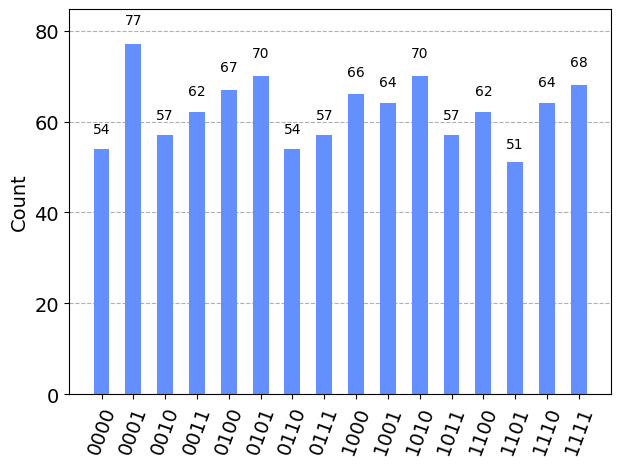

In [ ]:
import numpy as np
## Running the completed Grover's circuit:
output2_2=general_LightsOutPuzzle_with_noise(number_of_qubits2_2,lights2_2,target2_2,0.075)
counts2_2=output2_2[0]
plot_histogram(counts2_2)

The histogram provided shows the results of a quantum simulation with a  level of noise included. Unlike the earlier histograms where one state dominated the distribution, this histogram has a more uniform distribution of counts across different states. The target state no longer stands out with a significantly higher probability, as noise has introduced errors that have spread the probability across various states.

In this simulation, the peak count is around 77, and while it occurs at the target state, the presence of noise has significantly influenced the distribution of counts. The increased noise has introduced errors and distributed some probability to other states.


The histogram serves as a clear illustration of how quantum noise can disrupt the delicate interference patterns that quantum algorithms rely on to solve problems efficiently. As noise levels increase, the quantum advantage can be lost, highlighting the importance of developing noise-resistant quantum algorithms and error mitigation techniques to achieve reliable computation on near-term quantum devices.